<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score  
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.utils import shuffle



In [2]:
pd.options.display.max_columns

20

In [3]:
pd.options.display.max_columns = 25

In [4]:
data = pd.read_csv('Churn.csv')

In [5]:
print(data.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Замечены пропуски в столбце `'Tenure'`.

In [7]:
data_copy = data.copy()

In [8]:
data_copy = data_copy.fillna(0)

<AxesSubplot:>

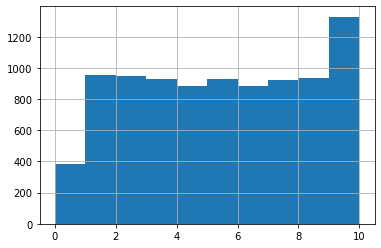

In [9]:
data.Tenure.hist()

<AxesSubplot:>

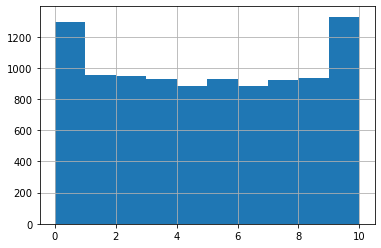

In [10]:
data_copy.Tenure.hist()

Распределение изменилось, если заменить пропуски нулями. Такой подход не подойдет.

In [11]:
data_copy = data.copy()

In [12]:
data_copy = data_copy.fillna(data_copy['Tenure'].median())

<AxesSubplot:>

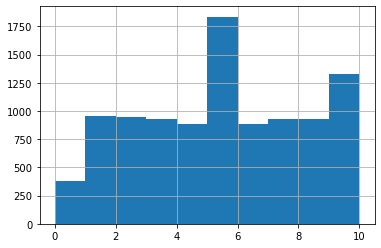

In [13]:
data_copy.Tenure.hist()

Распределение опять изменилось. Попробуем группировкой.

In [14]:
data_copy = data.copy()
data_copy['Tenure_gb'] = data_copy.groupby(
    ['NumOfProducts','HasCrCard','IsActiveMember','CreditScore'])['Tenure'].transform('median')
data_copy

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_gb
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,5.5
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,4.5
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,8.0
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,5.5
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,5.0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,8.5
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,6.0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,5.0


In [15]:
data_copy.loc[data_copy['Tenure'].isna(),'Tenure']= data_copy['Tenure_gb']

<AxesSubplot:>

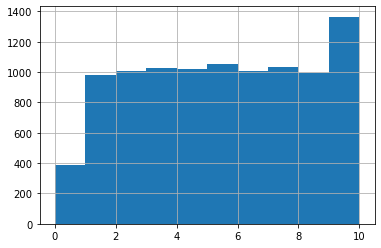

In [16]:
data_copy.Tenure.hist()

Распределение напоминает исходное.

In [17]:
data['Tenure_gb'] = data.groupby(
    ['NumOfProducts','HasCrCard','IsActiveMember','CreditScore'])['Tenure'].transform('median')
data.loc[data['Tenure'].isna(),'Tenure']= data['Tenure_gb']

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9872 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
 14  Tenure_gb        9872 non-null   float64
dtypes: float64(4), int64(8), object(3)
memory usage: 1.1+ MB


In [19]:
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_gb
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.002829,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571,0.009077
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021270,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248,-0.010830
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.001321,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.003719
Age,0.000783,0.009497,-0.003965,1.000000,-0.011035,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.014421
Tenure,-0.002829,-0.021270,-0.001321,-0.011035,1.000000,-0.008112,0.010596,0.029494,-0.034361,0.005115,-0.013762,0.558668
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.008112,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,-0.010975
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.010596,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.027365
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.029494,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.040739
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.034361,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.063871
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.005115,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.002820


<AxesSubplot:>

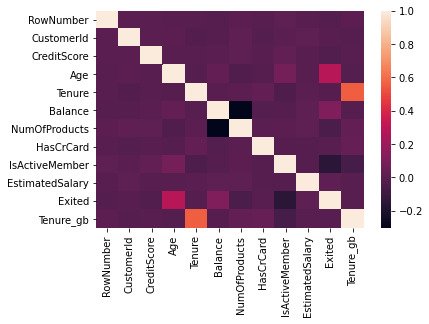

In [22]:
corr_of_data = data.corr()
sns.heatmap(corr_of_data,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [23]:
data = data.fillna(data['Tenure'].median())
data = data.dropna()

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
 14  Tenure_gb        10000 non-null  float64
dtypes: float64(4), int64(8), object(3)
memory usage: 1.2+ MB


In [104]:
data.NumOfProducts.unique()

array([1, 3, 2, 4], dtype=int64)

In [105]:
data.HasCrCard.unique()

array([1, 0], dtype=int64)

In [107]:
data.IsActiveMember.unique()

array([1, 0], dtype=int64)

In [25]:
print('Количесвто дубликатов:',data.duplicated().sum())

Количесвто дубликатов: 0


Удалим столбцы `'RowNumber','Surname','CustomerId','Tenure_gb'`

In [26]:
data = data.drop(['RowNumber','Surname','CustomerId','Tenure_gb'],axis=1)

In [28]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Столбец `'Geography'` и `'Gender'`

In [29]:
map_dict = {'Geography': None, 'Gender': None}
inv_map_dict = {'Geography': None, 'Gender': None}

for column in ['Geography','Gender']:
    le = LabelEncoder()
    le.fit(data[column])

    map_dict[column] = dict(zip(le.classes_, le.transform(le.classes_)))
    inv_map_dict[column] = {v: k for k, v in map_dict[column].items()}
    data[column] = le.transform(data[column])

In [30]:
inv_map_dict

{'Geography': {0: 'France', 1: 'Germany', 2: 'Spain'},
 'Gender': {0: 'Female', 1: 'Male'}}

Преобразовали категор. признаки.

In [31]:
data.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8.0,159660.80,3,1,0,113931.57,1


## Исследование задачи

Разделим выборки на тренировочные и валидационные.

In [32]:
def features_target(data):
    features = data.drop(['Exited'], axis=1)
    target = data['Exited']

    features_train, X, target_train, y = train_test_split(features, target, test_size=0.4, stratify=target, random_state=123)
    features_valid, features_test, target_valid, target_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=123)
    return features_train, features_valid, features_test, target_train, target_valid, target_test


In [33]:
features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data)

Масштабирование

In [34]:
features_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6255,547,1,1,55,5.0,111362.76,3,1,0,16922.28
7141,755,1,0,38,1.0,82083.52,1,0,1,10333.78
3824,667,0,1,44,5.0,122806.95,1,0,0,15120.86
1901,796,2,1,67,5.0,0.00,2,0,1,54871.02
2886,449,0,0,37,6.0,0.00,2,1,0,82176.48
...,...,...,...,...,...,...,...,...,...,...
7072,686,0,1,37,9.0,134560.62,1,1,0,27596.39
4167,850,2,1,34,8.0,199229.14,1,0,0,68106.29
1888,429,0,1,60,7.0,0.00,2,1,1,163691.48
926,738,2,1,35,3.0,0.00,1,1,1,15650.73


In [35]:
stand = StandardScaler()

num_columns = ['CreditScore','Age', 'Tenure', 'Balance','EstimatedSalary']

features_train[num_columns] = stand.fit_transform(features_train[num_columns])  
features_valid[num_columns] = stand.fit_transform(features_valid[num_columns]) 
features_test[num_columns] = stand.fit_transform(features_test[num_columns]) 

In [36]:
model = LogisticRegression(random_state=123)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('AUC_ROC:', auc_roc)

Accuracy: 0.795
Recall: 0.15196078431372548
F1 score: 0.23220973782771537
AUC_ROC: 0.7172381515420239


LogisticRegression: ROC AUC=0.717


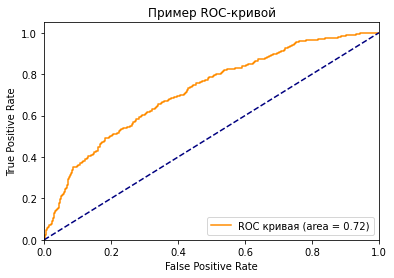

In [42]:
# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.8535
Recall: 0.42401960784313725
F1 score: 0.5414710485133021
RandomForestClassifier: ROC AUC=0.839


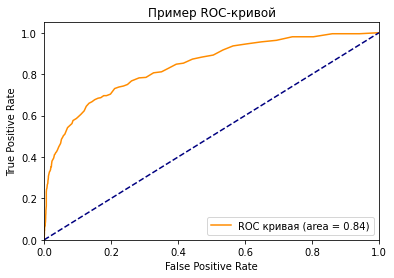

In [57]:
#features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data)

model = RandomForestClassifier(random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
print('RandomForestClassifier: ROC AUC=%.3f' % (auc_roc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, probabilities_one_valid)
roc_auc_forrest = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_forrest)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

## Борьба с дисбалансом

In [49]:
sum(data['Exited'])/len(data)

0.2037

воспользуемся техникой upsampling 

In [51]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled




Accuracy: 0.666
Recall: 0.6200980392156863
F1 score: 0.43100511073253833
LogisticRegression: ROC AUC=0.722


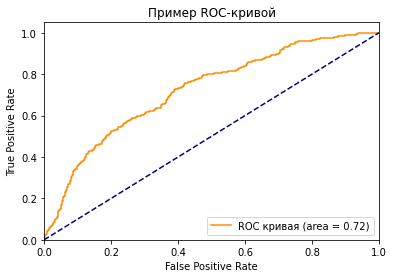

In [55]:
#features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state=12345,solver = 'liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)


probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)
#print('AUC_ROC:', auc_roc)



print('LogisticRegression: ROC AUC=%.3f' % (auc_roc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.8435
Recall: 0.5196078431372549
F1 score: 0.5753052917232022
RandomForestClassifier: ROC AUC=0.837


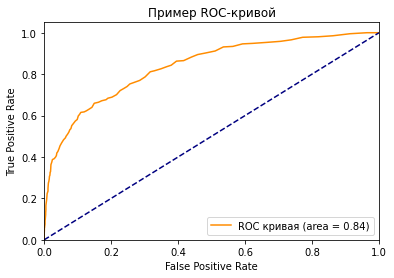

In [58]:
model = RandomForestClassifier(random_state = 45)
model.fit(features_upsampled, target_upsampled )
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('F1 score:', f1)



print('RandomForestClassifier: ROC AUC=%.3f' % (auc_roc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_valid, probabilities_one_valid)
roc_auc_forrest = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_forrest)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>верно, балансировка только трайна!

Картина по метрике F1 улучшилась.

downsampling


In [60]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled



In [61]:

#features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data_1_scal)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)


model = LogisticRegression(random_state = 12345,solver='liblinear')
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.43925233644859807


In [62]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)


model = RandomForestClassifier(random_state = 1234)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5870307167235495


In [64]:

#features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data_3_scal)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)


model = DecisionTreeClassifier(random_state = 1234)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46036294173829995


Лучше всего себя проевил downsampling на модели случайнного леса. Не плохо показал себя upsampling для второго набора данных на модели случайного леса.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>ОК, увидел.

## Тестирование модели

In [115]:
#features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data_3)
features_train, target_train = upsample(features_train, target_train,5)

best_result= 0
best_est = 0
best_depth = 0
best_result = 0.5
for est in range(100, 400, 20):#(1,200,2)(10,500,10)
    for depth in range (5, 15):#(1,15)(5,15)
        model = RandomForestClassifier(random_state=45, n_estimators=est ,max_depth=depth)
        model.fit(features_train,target_train) 
        predictions_valid = model.predict(features_valid)
        result = 0.5*f1_score(target_valid, predictions_valid)+0.5*precision_score(target_valid,predictions_valid)
        
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth
print('F_1 мера лучшей модели', best_result, ', Параметр "n_estimators":', best_est, ', Максимальная глубина:', best_depth)

F_1 мера лучшей модели 1.193049902005126 , Параметр "n_estimators": 380 , Максимальная глубина: 14


Результаты прогонок:


F_1 мера лучшей модели 0.6282973621103117 , Параметр "n_estimators": 27 , Максимальная глубина: 14


F_1 мера лучшей модели 0.625615763546798 , Параметр "n_estimators": 180 , Максимальная глубина: 14


F_1 мера лучшей модели 0.5951807228915663 , Параметр "n_estimators": 360 , Максимальная глубина: 13

Accuracy: 0.644
Recall: 0.773955773955774
Precision 0.33689839572192515
F1 score: 0.4694485842026825
RandomForestClassifier: ROC AUC=0.762


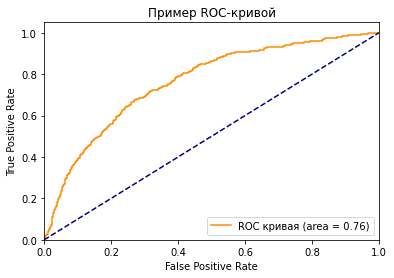

In [116]:
from sklearn.linear_model import LogisticRegression
    
model = LogisticRegression(random_state=45)
model.fit(features,target) 

predictions_test = model.predict(features_test)

probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

accuracy = accuracy_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
precision = precision_score(target_test,predictions_test)
f1 = f1_score(target_test, predictions_test)
auc_roc = roc_auc_score(target_test, probabilities_one)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision',precision)
print('F1 score:', f1)



print('RandomForestClassifier: ROC AUC=%.3f' % (auc_roc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, probabilities_one)
roc_auc_forrest = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_forrest)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()



In [100]:


features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data)

#features_train, target_train = upsample(features_train, target_train,5)
#features_train, target_train = downsample(features_train, target_train,0.3)

features = pd.concat([features_train, features_valid])
target = target_train.append(target_valid)

stand = StandardScaler()
num_columns = ['CreditScore','Age', 'Tenure', 'Balance','EstimatedSalary']

features[num_columns] = stand.fit_transform(features[num_columns])   
features_test[num_columns] = stand.fit_transform(features_test[num_columns])

features, target = upsample(features, target,5)





Accuracy: 0.839
Recall: 0.6658476658476659
Precision 0.5929978118161926
F1 score: 0.6273148148148149
RandomForestClassifier: ROC AUC=0.865


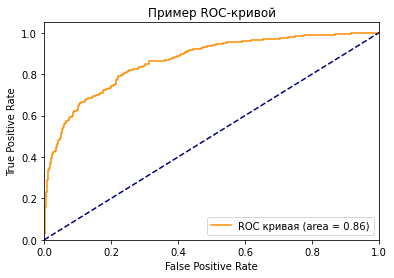

In [114]:
model = RandomForestClassifier(random_state=45, n_estimators=360 ,max_depth=13)
model.fit(features,target) 

predictions_test = model.predict(features_test)

probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

accuracy = accuracy_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
precision = precision_score(target_test,predictions_test)
f1 = f1_score(target_test, predictions_test)
auc_roc = roc_auc_score(target_test, probabilities_one)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision',precision)
print('F1 score:', f1)



print('RandomForestClassifier: ROC AUC=%.3f' % (auc_roc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, probabilities_one)
roc_auc_forrest = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_forrest)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>
<br/>ОК, Ислам, на самом деле добротная работа! <br>
Подготовка данных, разносторонняя работа с диссбалансом и исследование моделей и поиск парамтров для них - ничего не забыто <br>
И видно, что проделана рабочая аналитическая работа: результативно и с выводами.<br>  

<font color='green'>
Если говорить, что можно ещё улучшить в подобных проектах, то я бы выделили такие моменты:<br>   
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))<br> Очень ВАЖНАЯ для аналитики штука. Ведь нам не просто модель с метрикой нужна, а ещё и причины понять высокой/низкой метрики. Т.е. понять с какой силой сами факторы влияют на целевую.<br>
    
2) Наверняка знаешь, поэтому просто акцетрирую ещё раз: F1 и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" <br>   

В тексте - уже всё написал. Посомтри, пожалуйста:<br>
1) комментарий по масштабированию.<br>
2) комментарий по проверке на тесте.<br>

Спасибо) БУДУ ЖДАТЬ КОММЕНТАРИЕВ!

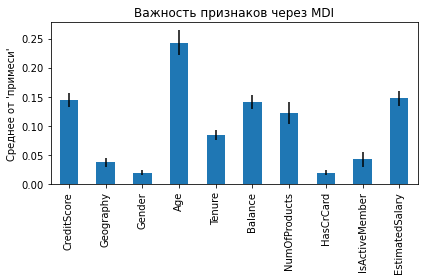

In [119]:


features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(data)

forest = RandomForestClassifier(random_state=145)
forest.fit(features_train, target_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

columns_data = features_train.columns
forest_importances = pd.Series(importances, index=columns_data)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность признаков через MDI")
ax.set_ylabel("Среднее от 'примеси'")
fig.tight_layout()

In [66]:
importances

array([0.15600815, 0.03769632, 0.01931618, 0.23420669, 0.05445761,
       0.15117501, 0.12909915, 0.02121076, 0.04270704, 0.15412309])

## Вывод


Подобрав параметры для модели `RandomForestClassifier` смогли получить приемлемую величину метрики F_1 = 0.61. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*

In [108]:
1600/250


6.4

In [109]:
6.4*1000


6400.0